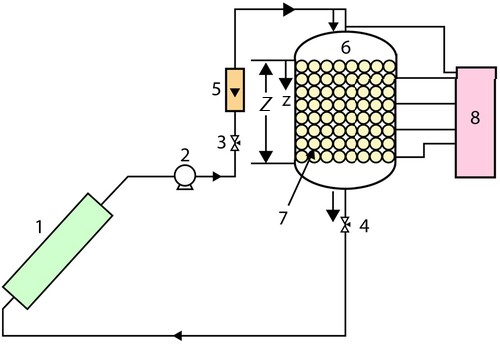

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *

In [2]:
# Parámetros, constantes e información conocida del sistema

Z = 0.47                     # m (largo del tanque)
d = 0.36                     # m (diámmetro del tanque)
A = (np.pi * d**2) / 4       # m2 (área transversal del tanque)

dp = 0.055                   # m (diámetro de partícula)
ep = 0.49                    # porosidad

mfr = 2 / 60.0               # kg/s (mass flow rate)
Qu = 375.0                   # W (potencia térmica aplicada al circuito)

rho_f = 998.0                # kg/m3 (agua)
mu = 0.89e-3                 # Pa·s (viscosidad dinámica del agua a ~25 °C)
k_f = 0.598                  # W/m·K (conductividad del fluido)
cp_f = 4181.3                # J/kg·K (capacidad calorífica del agua)
u = mfr / (rho_f * A)        # m/s (velocidad promedio del HTF en el lecho)

rho_s = 789.0                # kg/m3 (pcm sólido)
rho_l = 750.0                # kg/m3 (pcm líquido)
cp_s = 1800.0                # J/kg·K (capacidad calorífica del pcm sólido)
cp_l = 2400.0                # J/kg·K (capacidad calorífica del pcm líquido)
L = 206000.0                 # J/kg (calor latente del pcm)
k_s = 0.18                   # W/m·K (conductividad del pcm sólido)
k_l = 0.19                   # W/m·K (conductividad del pcm líquido)
Tpc = 300.7                  # K (punto de cambio de fase pcm)

dTpc = 1.49997723            # K (ancho de la zona de fusión)

Re = dp * u * rho_f / (mu*(1-ep))         # número de Reynolds
Pr = mu * cp_f / k_f                      # número de Prandtl
Nu = 2.0 + 1.1 * Re**0.6 * Pr**(1.0/3.0)  # número de Nusselt

In [3]:
# Propiedades dependientes de la fase

def x(T):
    """Fracción líquida aproximada en la zona de fusión (0 a 1)."""
    if T < Tpc - dTpc/2:
        return 0.0
    elif T > Tpc + dTpc/2:
        return 1.0
    else:
        return (T - (Tpc - dTpc/2)) / dTpc

def rho_eff(T):
    """Densidad efectiva del PCM (lineal entre sólido y líquido)."""
    return rho_s * (1.0 - x(T)) + rho_l * x(T)

def cp_eff(T):
    """Capacidad calorífica efectiva con un término para latente distribuido en dTpc.
       He usado los valores que tenías (1800 y 2400 J/kgK) y distribuí el calor latente
       en la banda dTpc mediante un término adicional.
    """
    if T < Tpc - dTpc/2:
        return cp_s
    elif T > Tpc + dTpc/2:
        return cp_l
    else:
        return cp_s * (1.0 - x(T)) + cp_l * x(T) + L / dTpc

def k_eff(T):
    """Conductividad efectiva del PCM (W/mK)
       Usé los valores que tenías 0.18/0.19 W/mK; ajústalos si tienes otros.
    """
    return k_s * (1.0 - x(T)) + k_l * x(T)

def h_vol(T):
    """Coeficiente volumétrico de transferencia de calor entre HTF y PCM (W/m3K).
       Se usa: h = Nu * k_eff / dp  (h superficial)  y luego se escala volumétricamente.
       Factor 6*(1-ep)/(ep*dp) viene de la relación área/volumen para esferas en lecho.
    """
    h_surf = 13.0001074 #W/m2K (coefs superficial); 13.0001074 -> obtenido por ajuste de parámetros, para usar valor teórico remplazar por : Nu * k_eff(T) / dp
    h_vol_local = h_surf * 6.0 * (1.0 - ep) / (ep * dp)  # W/m3K
    return h_vol_local

In [4]:
# ODEs

# Discretización espacial
N = 50
dz = Z/(N-1)

# Función de derivadas
def dTdt(t,T):
   # Desempaquetamiento de variables
   T_HTF_interior = T[:N]
   T_PCM = T[N:]

   # Incorporación de CB
   T_HTF = np.zeros(N+1)
   T_HTF[1:] = T_HTF_interior
   T_HTF[0] = Qu/(mfr*cp_f) + T_HTF_interior[-1]

   # Vectores de derivadas
   dTfdt_interior = np.zeros(len(T_HTF_interior))
   dTsdt = np.zeros(len(T_PCM))

   # Derivadas HTF
   for i in range(1, N+1):
      ter_adv = -(u/ep)*(T_HTF[i] - T_HTF[i-1])/dz
      ter_convec = h_vol(T_PCM[i])/(rho_f*cp_f*ep)*(T_PCM[i] - T_HTF[i])
      dTfdt_interior[i-1] = ter_adv + ter_convec

    # Derivadas PCM
   for i in range(0, N+1):
      dTsdt[i] = h_vol(T_PCM[i])/(rho_eff(T_PCM[i])*cp_eff(T_PCM[i])*(1 - ep))*(T_HTF[i] - T_PCM[i])

   # Concatenación de vectores de derivadas
   dTdt = np.concatenate([dTfdt_interior, dTsdt])

   return dTdt

In [5]:
# CI
T_HTF_0 = np.ones(N)*298.15
T_PCM_0 = np.ones(N+1)*298.15

T_0 = np.concatenate([T_HTF_0, T_PCM_0])

# Integración
t_plot = np.array([0.0, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50])
t_end = t_plot[-1]*3600
t_span = (0, t_end)
t_eval = t_plot*3600

sol = solve_ivp(dTdt, t_span, T_0, method= 'BDF', atol=1e-6, rtol=1e-6)

In [6]:
# Extracción de resultados

# Fracción de largo en el tanque TES
pos_frac = [0.95, 1-0.235, 1-0.42]

# Coordenada espacial normalizada
z = np.linspace(0, 1, N+1)

# Búsqueda de índice
idx = [int(np.argmin(np.abs(z-pos))) for pos in pos_frac]

# Perfiles de temperatura HTF y PCM
Tf_profile = np.zeros((len(idx), len(sol.t)))  #np.zeros((len(idx), len(t_eval)))
Ts_profile = np.zeros((len(idx), len(sol.t)))  #np.zeros((len(idx), len(t_eval)))

for k, t in enumerate(sol.t): #enumerate(t_eval):
    solution_at_t = sol.y[:, k]
    T_htf_interior = solution_at_t[:N]
    T_htf_full = np.zeros(N+1)
    T_htf_full[1:] = T_htf_interior
    T_htf_full[0] = Qu/(mfr*cp_f) + T_htf_full[-1]

    T_pcm = solution_at_t[N:]

    for i, j in enumerate(idx):
        Tf_profile[i, k] = T_htf_full[j]
        Ts_profile[i, k] = T_pcm[j]

In [10]:
# Perfiles de referencia (no editar a menos que se quiera hacer ajuste nuevo)

t_pcm_ref = np.array([
    0.07927, 0.11353, 0.14605, 0.17728, 0.21543, 0.26227, 0.30662, 0.34572,
    0.38492, 0.42314, 0.46434, 0.50467, 0.53883, 0.57969, 0.61785, 0.65427,
    0.69763, 0.73614, 0.77395, 0.81350, 0.84854, 0.89190, 0.92813, 0.96822,
    1.00603, 1.04454, 1.08201, 1.12086, 1.15798, 1.19718, 1.23360, 1.27350,
    1.31166, 1.35086, 1.38798, 1.42652, 1.46430, 1.49899, 1.54062, 1.57877,
    1.61763, 1.65509, 1.69221, 1.73141, 1.76957, 1.80889, 1.84589, 1.88232,
    1.92568, 1.96384, 2.00161, 2.04016, 2.07832, 2.11995, 2.15464, 2.19176,
    2.23096, 2.26912, 2.30843, 2.34544, 2.38360, 2.42445, 2.45992, 2.49538,
    2.53623, 2.57439, 2.61294, 2.65071, 2.68887, 2.73397, 2.77213, 2.81029,
    2.84845, 2.88661, 2.92616, 2.96293, 3.00005, 3.03925, 3.07741, 3.11827,
    3.15373, 3.19154, 3.23005, 3.26682, 3.30637, 3.34453, 3.38962, 3.42778,
    3.46733, 3.50410, 3.54330, 3.57869, 3.61858, 3.65570, 3.69490, 3.73113,
    3.76949, 3.80938, 3.84893, 3.88605, 3.92386, 3.95932, 3.99914, 4.03834,
    4.07551, 4.11379, 4.14805, 4.17479, 4.17710, 4.18866, 4.19271, 4.20138,
    4.20659, 4.21699, 4.22046, 4.22740, 4.23781, 4.24128, 4.24995, 4.26036,
    4.27423, 4.28811, 4.30372, 4.31586, 4.33147, 4.34477, 4.35865, 4.37484,
    4.38871, 4.40490, 4.41878, 4.43208, 4.45462, 4.47284, 4.48931, 4.51013,
    4.53580, 4.55731, 4.58100, 4.60726, 4.63502, 4.66797, 4.70049, 4.73215,
    4.75990
])

temp_pcm_ref = np.array([
    298.50340, 298.68236, 298.83165, 298.98743, 299.18295, 299.38060,
    299.48922, 299.58460, 299.67149, 299.76727, 299.85443, 299.95179,
    299.97529, 300.00001, 300.01856, 300.03710, 300.06678, 300.07865,
    300.08903, 300.11648, 300.11870, 300.15579, 300.16074, 300.17872,
    300.19363, 300.21514, 300.22404, 300.24481, 300.25149, 300.28190,
    300.28116, 300.30416, 300.30416, 300.32790, 300.33383, 300.35032,
    300.36350, 300.36268, 300.39520, 300.39925, 300.41469, 300.42285,
    300.43027, 300.45994, 300.45994, 300.47890, 300.48961, 300.48961,
    300.51928, 300.51928, 300.53577, 300.55638, 300.55638, 300.57121,
    300.57121, 300.58456, 300.60898, 300.60830, 300.62808, 300.63798,
    300.63798, 300.66435, 300.66765, 300.67095, 300.69732, 300.69732,
    300.71793, 300.73441, 300.73441, 300.76408, 300.76408, 300.78189,
    300.80118, 300.80050, 300.82120, 300.82343, 300.82936, 300.85310,
    300.85310, 300.87948, 300.88278, 300.89242, 300.91245, 300.91542,
    300.94212, 300.94212, 300.97247, 300.97179, 301.00592, 301.00754,
    301.03781, 301.04597, 301.07430, 301.07861, 301.09790, 301.10697,
    301.13499, 301.16062, 301.18469, 301.20769, 301.23885, 301.25616,
    301.28707, 301.32787, 301.36814, 301.45861, 301.57359, 301.72597,
    301.84714, 302.06721, 302.23288, 302.48139, 302.61306, 302.88383,
    303.03404, 303.21909, 303.47728, 303.61266, 303.79812, 304.03828,
    304.29884, 304.54587, 304.81440, 305.06168, 305.35037, 305.55622,
    305.71448, 305.90858, 306.08848, 306.28568, 306.47113, 306.60775,
    306.81879, 306.99164, 307.12887, 307.32546, 307.50572, 307.65556,
    307.84208, 308.00916, 308.17929, 308.37513, 308.56707, 308.72934,
    308.89069
])

t_htf_ref = np.array([
    0.06627, 0.08535, 0.10789, 0.13218, 0.15299, 0.17207, 0.19289, 0.21543,
    0.23798, 0.25880, 0.29739, 0.33165, 0.36287, 0.39236, 0.42982, 0.46694,
    0.50163, 0.52938, 0.57969, 0.61785, 0.65601, 0.68921, 0.73024, 0.77048,
    0.80864, 0.84160, 0.88496, 0.93700, 0.97516, 1.01332, 1.06362, 1.11392,
    1.15208, 1.19024, 1.22233, 1.26032, 1.30472, 1.34635, 1.38451, 1.42475,
    1.45875, 1.49899, 1.53715, 1.57531, 1.60306, 1.63948, 1.69672, 1.73488,
    1.77304, 1.79733, 1.83895, 1.89099, 1.92915, 1.96731, 1.99506, 2.03842,
    2.09358, 2.13035, 2.16851, 2.19453, 2.23790, 2.28993, 2.32809, 2.36625,
    2.39400, 2.43563, 2.49461, 2.53277, 2.57093, 2.60041, 2.63857, 2.69581,
    2.73397, 2.77213, 2.79988, 2.83631, 2.89355, 2.93171, 2.96987, 2.99935,
    3.04272, 3.09128, 3.12944, 3.17030, 3.19882, 3.24219, 3.29249, 3.33065,
    3.37020, 3.39483, 3.43819, 3.49231, 3.53532, 3.57348, 3.61789, 3.65587,
    3.68796, 3.72612, 3.76428, 3.81690, 3.85795, 3.89611, 3.93080, 3.98006,
    4.02446, 4.06262, 4.09582, 4.13408, 4.17016, 4.20832, 4.23954, 4.28018,
    4.31933, 4.35749, 4.38941, 4.43480, 4.47197, 4.51013, 4.54829, 4.60726,
    4.64542, 4.67317, 4.70836, 4.74949, 4.77725
])

temp_htf_ref = np.array([
    298.68848, 298.86730, 299.07027, 299.31344, 299.50052, 299.67757,
    299.86649, 300.09525, 300.27737, 300.44325, 300.66672, 300.82096,
    300.97303, 301.11910, 301.29572, 301.47969, 301.65105, 301.75153,
    301.94110, 302.08812, 302.22501, 302.34204, 302.49697, 302.63481,
    302.73327, 302.81830, 302.93761, 303.06686, 303.16892, 303.25839,
    303.34561, 303.44564, 303.50881, 303.57714, 303.64233, 303.71206,
    303.76170, 303.82397, 303.86533, 303.92571, 303.97022, 304.01459,
    304.05505, 304.08473, 304.11413, 304.14677, 304.22185, 304.25152,
    304.28434, 304.29761, 304.33569, 304.37471, 304.41248, 304.42776,
    304.45240, 304.48801, 304.51174, 304.52982, 304.54465, 304.58073,
    304.60670, 304.62288, 304.63637, 304.65121, 304.66753, 304.69324,
    304.73393, 304.74382, 304.77035, 304.77237, 304.79957, 304.82182,
    304.82699, 304.85150, 304.85150, 304.87746, 304.92051, 304.93040,
    304.94591, 304.94340, 304.97866, 305.00391, 305.03897, 305.05920,
    305.06662, 305.09630, 305.14485, 305.18869, 305.23774, 305.25950,
    305.31142, 305.37250, 305.44158, 305.52115, 305.60370, 305.66749,
    305.73583, 305.80754, 305.88509, 306.04829, 306.16676, 306.27668,
    306.37304, 306.53146, 306.66602, 306.82383, 306.94589, 307.11404,
    307.28870, 307.45370, 307.58138, 307.76436, 307.89834, 308.05794,
    308.18572, 308.35852, 308.51854, 308.65432, 308.80662, 309.06344,
    309.22777, 309.33899, 309.53377, 309.70118, 309.82760
])

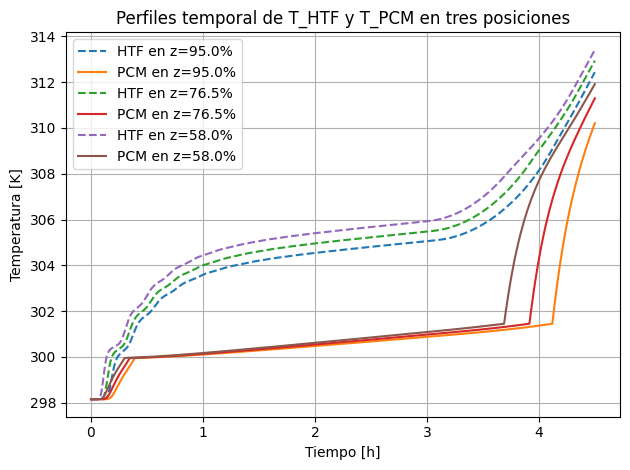

In [13]:
# Gráfico
plt.figure()

for i, p in enumerate(pos_frac):
    plt.plot(sol.t/3600, Tf_profile[i], '--', label = f"HTF en z={(p)*100:.1f}%")
    plt.plot(sol.t/3600, Ts_profile[i], label = f"PCM en z={(p)*100:.1f}%")

# Descomentar para visualizar perfiles de referencia con los que se realizó ajuste de dTpc y h_surf
#plt.plot(t_pcm_ref, temp_pcm_ref, ':', label = "Temperatura de referencia pcm")
#plt.plot(t_htf_ref, temp_htf_ref, ':', label = "Temperatura de referencia htf")

plt.xlabel("Tiempo [h]")
plt.ylabel("Temperatura [K]")
plt.title("Perfiles temporal de T_HTF y T_PCM en tres posiciones")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()